Processing Dataset...

Training SVM Classifier...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



Best SVM Parameters: {'C': 0.1, 'kernel': 'linear'}
Classification Accuracy: 0.89


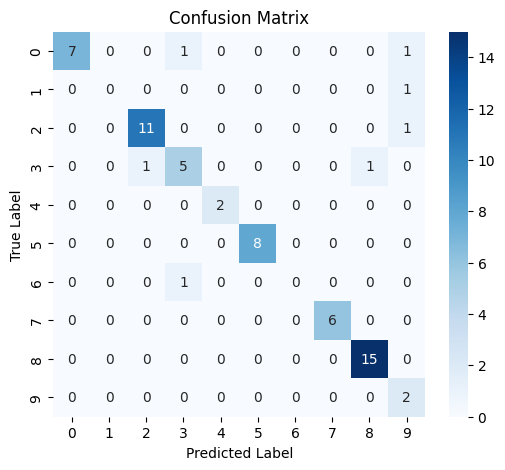


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.00      0.00      0.00         1
           2       0.92      0.92      0.92        12
           3       0.71      0.71      0.71         7
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         8
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         6
           8       0.94      1.00      0.97        15
           9       0.40      1.00      0.57         2

    accuracy                           0.89        63
   macro avg       0.70      0.74      0.70        63
weighted avg       0.89      0.89      0.88        63



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

DATASET_PATH = "/content/drive/MyDrive/Speech_Understanding/Assignment_1/audio"

def load_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def apply_stft(y, sr, window_type):
    n_fft = 2048
    hop_length = 512
    windows = {
        "hann": np.hanning(n_fft),
        "hamming": np.hamming(n_fft),
        "rectangular": np.ones(n_fft),
    }
    window = windows.get(window_type, np.ones(n_fft))
    stft_result = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    return np.abs(stft_result), sr

def plot_spectrogram(stft_result, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(stft_result, ref=np.max),
                             sr=sr, hop_length=512, y_axis='log', x_axis='time')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()

def extract_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta = librosa.feature.delta(mfccs)
    delta_delta = librosa.feature.delta(mfccs, order=2)
    feature_vector = np.hstack([np.mean(mfccs, axis=1), np.mean(delta, axis=1), np.mean(delta_delta, axis=1)])
    return feature_vector

def process_dataset(dataset_path):
    X, y_labels = [], []
    for subdir, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(subdir, file)
                y, sr = load_audio(file_path)
                features = extract_features(y, sr)
                X.append(features)
                y_labels.append(int(file.split("-")[1]))
    return np.array(X), np.array(y_labels)

def train_svm_classifier(X, y_labels):
    X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

    # Grid search for best SVM parameters
    param_grid = {'C': [0.1,0.3,0.5,1,5, 10], 'kernel': ['linear', 'rbf']}
    grid_search = GridSearchCV(SVC(), param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    best_svm = grid_search.best_estimator_
    y_pred = best_svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nBest SVM Parameters: {grid_search.best_params_}")
    print(f"Classification Accuracy: {accuracy:.2f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_labels), yticklabels=np.unique(y_labels))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


def compare_windowing(file_path):
    y, sr = load_audio(file_path)
    for window in ["hann", "hamming", "rectangular"]:
        stft_result, sr = apply_stft(y, sr, window)
        plot_spectrogram(stft_result, sr, f"Spectrogram with {window.capitalize()} Window")


if __name__ == "__main__":
    print("Processing Dataset...")
    X, y_labels = process_dataset(DATASET_PATH)

    print("\nTraining SVM Classifier...")
    train_svm_classifier(X, y_labels)



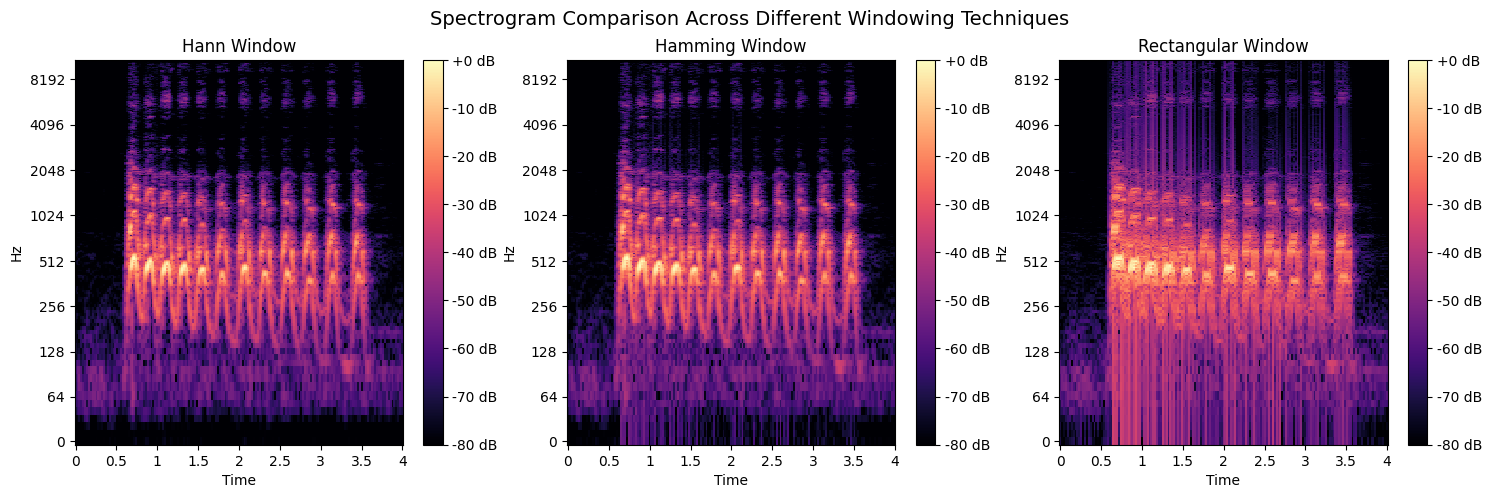

In [35]:
def compare_spectrograms_side_by_side(file_path):
    y, sr = load_audio(file_path)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, window in enumerate(["hann", "hamming", "rectangular"]):
        stft_result, sr = apply_stft(y, sr, window)
        img = librosa.display.specshow(librosa.amplitude_to_db(stft_result, ref=np.max),
                                       sr=sr, hop_length=512, y_axis='log', x_axis='time', ax=axes[idx])
        axes[idx].set_title(f"{window.capitalize()} Window")
        fig.colorbar(img, ax=axes[idx], format="%+2.0f dB")

    plt.suptitle("Spectrogram Comparison Across Different Windowing Techniques", fontsize=14)
    plt.show()

sample_file = "/content/drive/MyDrive/Speech_Understanding/Assignment_1/audio/fold1/101415-3-0-3.wav"
compare_spectrograms_side_by_side(sample_file)